<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/fig1a_b/pbmcAnalysis_l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname

download_file('10.22002/D1.2175','.tar.gz') 



#os.system("tar -xvf *.tar.gz")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/422469 [00:00<?, ?B/s]

'D1.2175.tar.gz'

In [2]:
!tar -xvf D1.2175.tar.gz

logPBMC.mtx
pca30PBMC.mtx
scalePBMC.mtx
._stimLabsPBMC.csv
stimLabsPBMC.csv
umapPBMC.mtx
logPBMCOrig.mtx


In [3]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 145 (delta 3), reused 2 (delta 2), pack-reused 137
Receiving objects: 100% (145/145), 419.61 KiB | 11.99 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [4]:
%cd /content/densvis/densne/

/content/densvis/densne


In [5]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [6]:
%cd /content/

/content


In [7]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 390 (delta 22), reused 18 (delta 15), pack-reused 360
Receiving objects: 100% (390/390), 149.92 MiB | 23.86 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [8]:
%cd /content/CP_2022/scripts

/content/CP_2022/scripts


In [9]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.7.0rc1
!pip3 install --quiet umap-learn

     |████████████████████████████████| 96 kB 4.2 MB/s 
     |████████████████████████████████| 10.2 MB 14.3 MB/s 
     |████████████████████████████████| 69 kB 8.1 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


## **Install Packages**

In [40]:
import statistics
import sklearn.preprocessing
import anndata 
import pandas as pd
import numpy as np

from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


## **Analysis of PBMC Data**
Data from seurat tutotial at https://github.com/satijalab/seurat/blob/master/vignettes/integration_introduction.Rmd

In [11]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

n_latent = 50
pcs = 30 #Following Seurat implementation example


In [12]:
logMat = sio.mmread(data_path+'/logPBMC.mtx').todense()
scaleMat = sio.mmread(data_path+'/scalePBMC.mtx').todense()

pcaMat = sio.mmread(data_path+'/pca30PBMC.mtx').todense()
umapMat = sio.mmread(data_path+'/umapPBMC.mtx').todense()

In [13]:
#Pre-integration matrix
logMatOrig = sio.mmread(data_path+'/logPBMCOrig.mtx').todense()


In [14]:
logMatOrig = logMatOrig.T

In [15]:
logMat = logMat.T
scaleMat = scaleMat.T
scaleMat.shape

(13999, 2000)

In [16]:
conds = pd.read_csv(data_path+'/stimLabsPBMC.csv')
conds.head()

,Unnamed: 0,x
0,AAACATACATTTCC.1,CTRL
1,AAACATACCAGAAA.1,CTRL
2,AAACATACCTCGCT.1,CTRL
3,AAACATACCTGGTA.1,CTRL
4,AAACATACGATGAA.1,CTRL


In [17]:
#Get pca and umap coordinates for original log count matrix  (pre-integration)
reducer = umap.UMAP(n_components = ndims, random_state = state)

logScaleOrig = sklearn.preprocessing.scale(logMatOrig)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [18]:
#PCA 
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(logScaleOrig)



pcaUMAP = reducer.fit_transform(x_pca)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [34]:
#PCA  for integrated
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(logMat)



pcaUMAPInt = reducer.fit_transform(x_pca)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [52]:
# PCA 50D UMAP 2D, PCA 100D UMAP 2D,PCA 2D, UMAP 2D (no coupling), 

tsvd = TruncatedSVD(n_components=50)
x_pca_50 = tsvd.fit_transform(logMatOrig)
pcaUMAP50 = reducer.fit_transform(x_pca_50)


tsvd = TruncatedSVD(n_components=100)
x_pca_100 = tsvd.fit_transform(logMatOrig)
pcaUMAP100 = reducer.fit_transform(x_pca_100)

tsvd = TruncatedSVD(n_components=2)
x_pca_2 = tsvd.fit_transform(logMatOrig)


origUMAP2 = reducer.fit_transform(logMatOrig)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

Repeat the same for the integrated ambient data

In [53]:
# PCA 50D UMAP 2D, PCA 100D UMAP 2D,PCA 2D, UMAP 2D (no coupling), 

tsvd = TruncatedSVD(n_components=50)
x_pca_50_intg = tsvd.fit_transform(logMat)
pcaUMAP50_intg = reducer.fit_transform(x_pca_50_intg)


tsvd = TruncatedSVD(n_components=100)
x_pca_100_intg = tsvd.fit_transform(logMat)
pcaUMAP100_intg = reducer.fit_transform(x_pca_100_intg)

tsvd = TruncatedSVD(n_components=2)
x_pca_2_intg = tsvd.fit_transform(logMat)


origUMAP2_intg = reducer.fit_transform(logMat)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

In [ ]:
# #Get pca and umap coordinates for original log count matrix 
# reducer = umap.UMAP(n_components = ndims, random_state = state)


In [ ]:
# #PCA 
# tsvd = TruncatedSVD(n_components=pcs)
# x_pca = tsvd.fit_transform(scaleMat)



# pcaUMAP = reducer.fit_transform(x_pca)


Plot 2D Embeddings

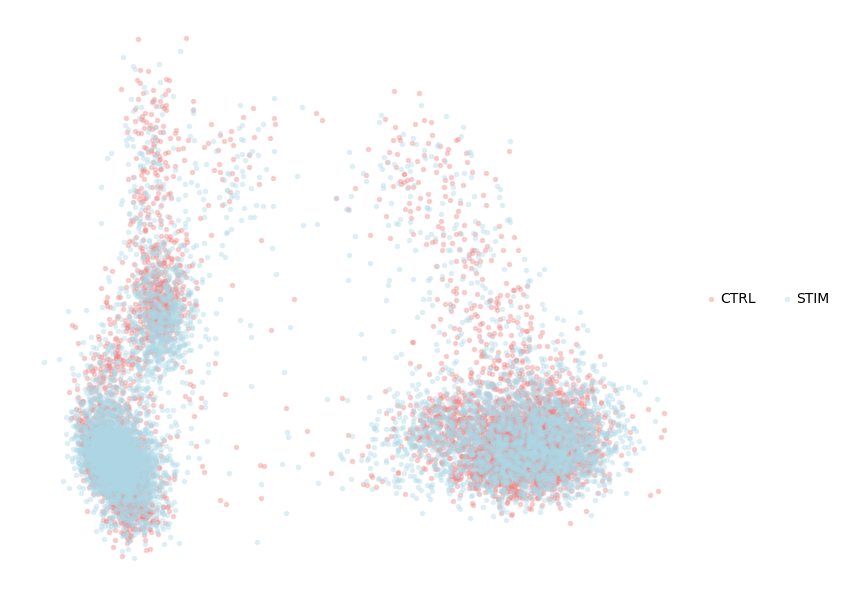

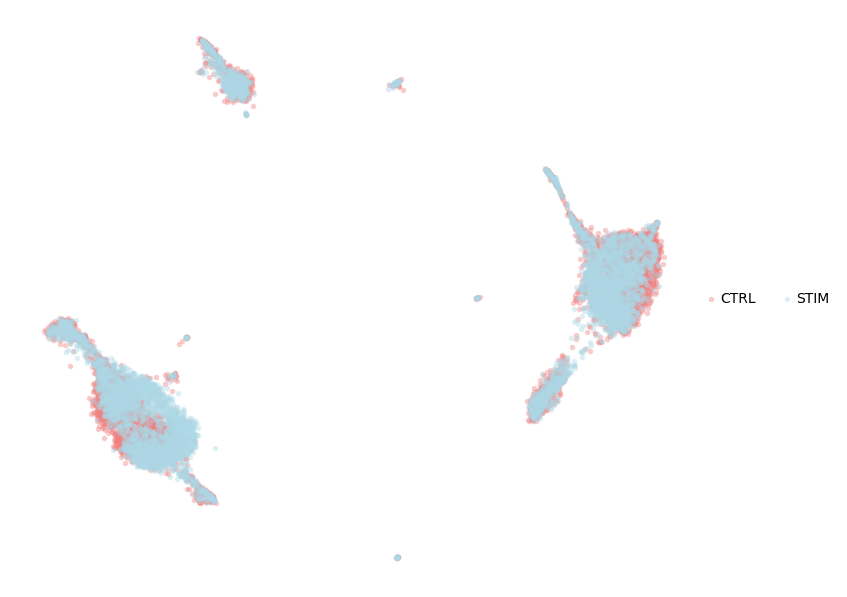

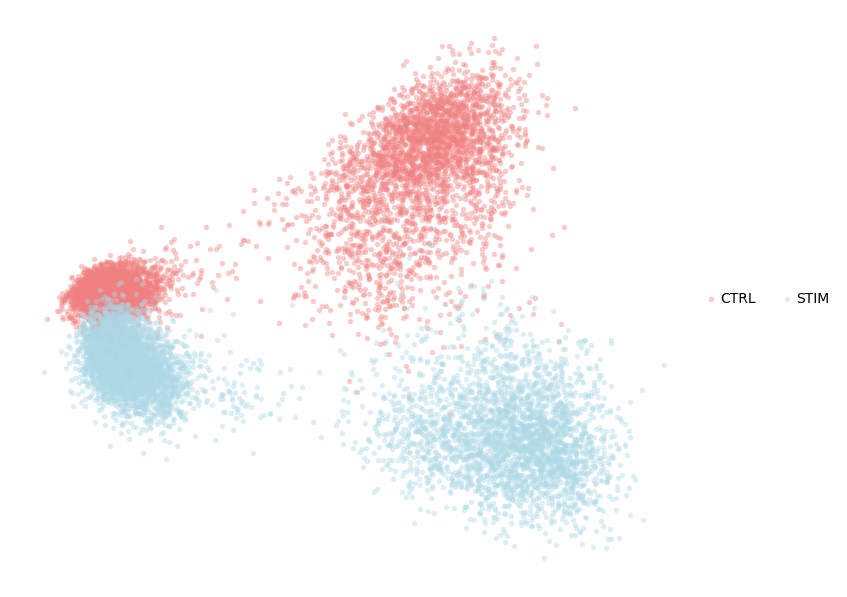

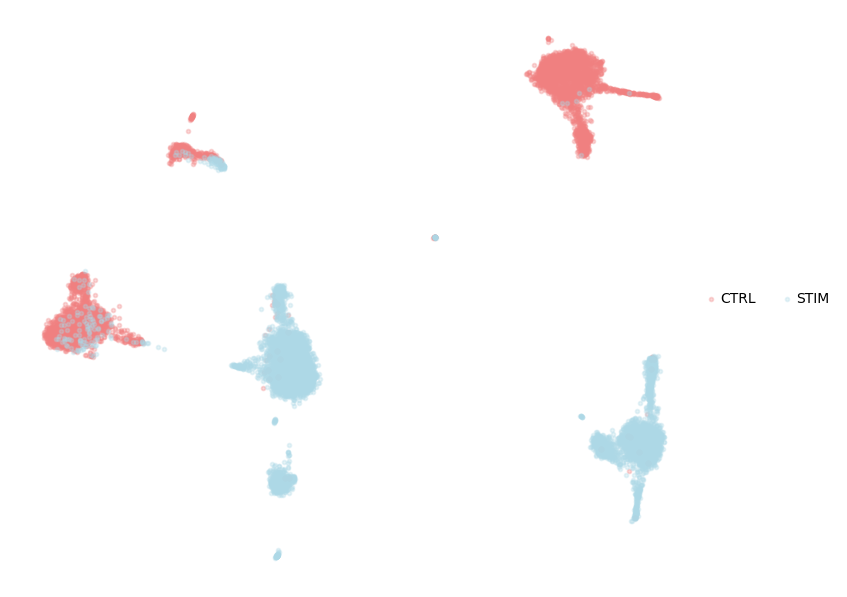

In [ ]:
#Plot straight to 2D plots
#Integrated data 2d UMAP and PCA

vis.obj_plot_embed(np.asarray(x_pca_2_intg), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)
vis.obj_plot_embed(np.asarray(origUMAP2_intg), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

#Un-Integrated data 2d UMAP and PCA

vis.obj_plot_embed(np.asarray(x_pca_2), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)
vis.obj_plot_embed(np.asarray(origUMAP2), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

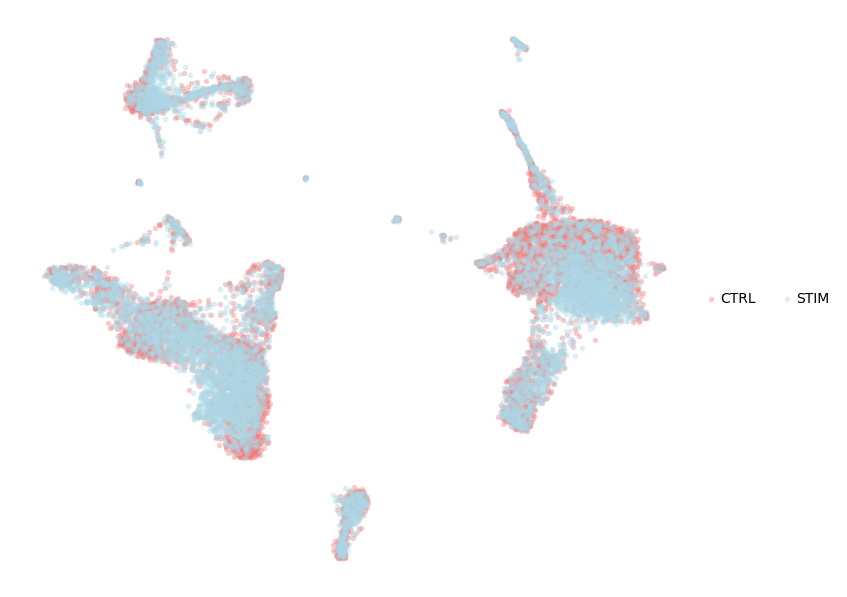

In [ ]:
#Integrated data + umap

vis.obj_plot_embed(np.asarray(umapMat), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

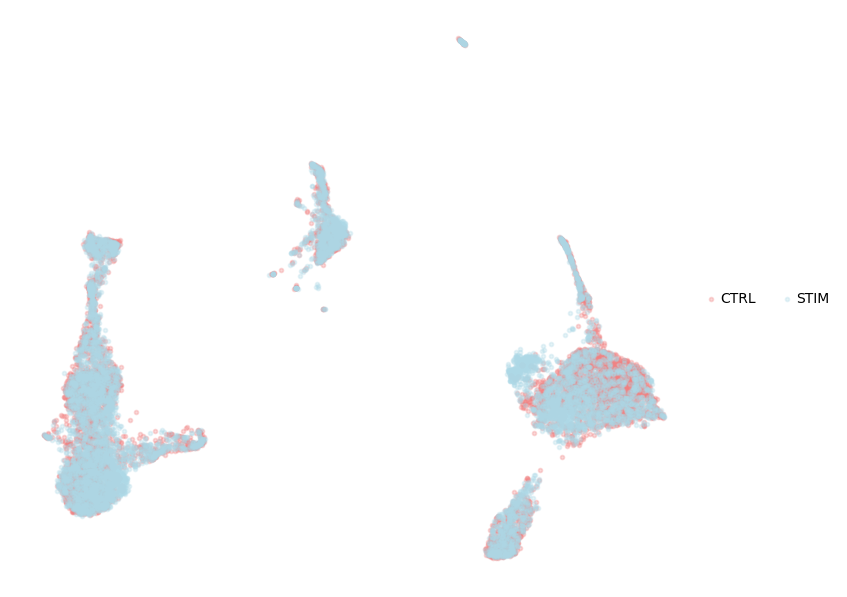

In [39]:
#Integrated data + umap WITH LOG MAT AS INPUT

vis.obj_plot_embed(np.asarray(pcaUMAPInt), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

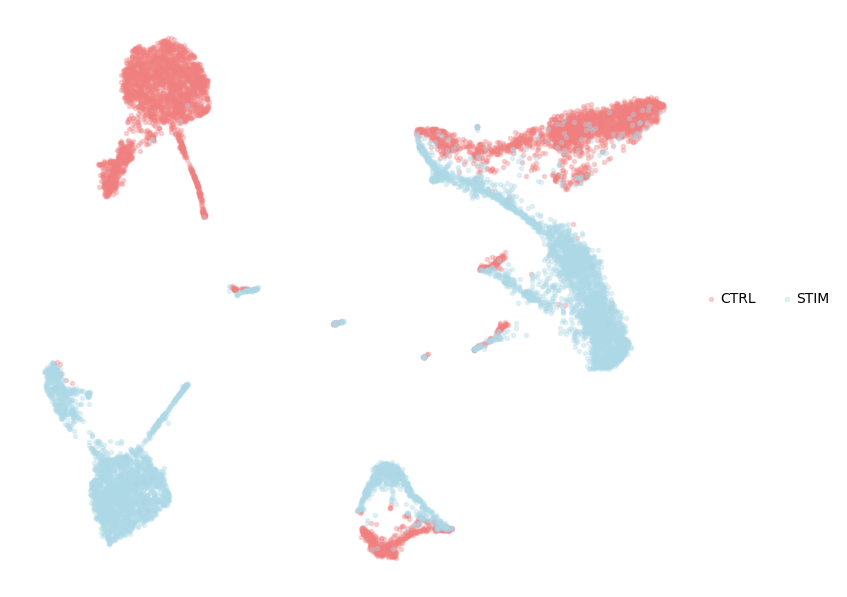

In [ ]:
#Pre-intergated log mat + umap

vis.obj_plot_embed(pcaUMAP, conds['x'], fname = 'logOrigUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

Count neighbor mixing

In [21]:
def frac_unique_neighbors(latent, cluster_label, metric = 2,neighbors = 30):
    """ Calculates the fraction of nearest neighbors from same cell type
    
    Returns:
    output: dictionary mapping each unique label in the category cluster_label
    to the fraction of neighbors in the same cluster, for each point in the cluster
    """
    cats = pd.Categorical(cluster_label)
    # Get nearest neighbors in each space
    n = neighbors
    neigh = NearestNeighbors(n_neighbors=n, p=metric)
    # Get transformed count matrices
    clusters = np.unique(cluster_label)
    unique_clusters = {}
    frac_neighbors = {}
    X_full  = latent
    neigh.fit(X_full)
    for c in clusters:
        X  = latent[cats == c, :]
        # Find n nearest neighbor cells (L1 distance)
        kNeigh = neigh.kneighbors(X)
        matNeigh = kNeigh[1]
        frac = np.zeros(matNeigh.shape[0])
        #How many of top n neighbors come from same cluster in the labeled data (out of n neighbors)
        unique_clusters[c] = np.unique([cats[matNeigh[i]] for i in range(0, len(frac))])
        frac_neighbors[c] = [cats[matNeigh[i]].value_counts()[c]/n for i in range(0,len(frac))]
    return frac_neighbors, unique_clusters

#### Make plots for integrated ambient/embedded data

**Plots for Integrated Data**

In [35]:
logNeigh, logClus = frac_unique_neighbors(np.asarray(logMat), conds['x']) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(pcaMat), conds['x']) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pcaUMAPInt), conds['x']) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latent = ['Log-Normalized Ambient','PCA 30D','30D PCA UMAP']

In [36]:
#Make dataframe

integDF = pd.DataFrame()
integDF['Fraction'] = latents[0] + latents[1] + latents[2]
integDF['Embed'] = ['Log-Normalized Ambient']*len(latents[0]) + ['PCA 30D']*len(latents[1]) + ['30D PCA UMAP']*len(latents[2])
integDF.head()

,Fraction,Embed
0,0.966667,Log-Normalized Ambient
1,0.900000,Log-Normalized Ambient
2,1.000000,Log-Normalized Ambient
3,0.533333,Log-Normalized Ambient
4,1.000000,Log-Normalized Ambient


In [37]:
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['30D PCA UMAP'])]))

1.0
0.7666666666666667
0.5333333333333333


<Figure size 1250x625 with 0 Axes>

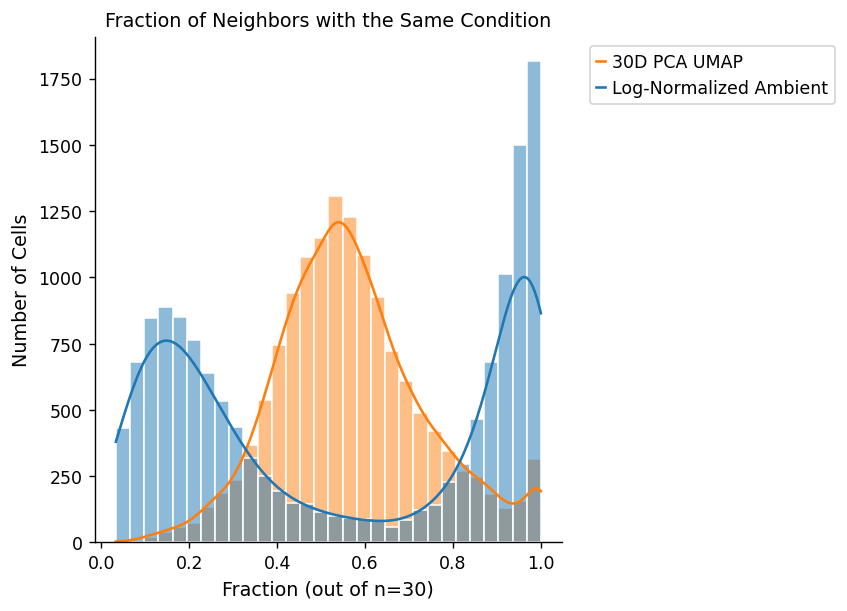

In [41]:
plt.figure(figsize=(10,5))

integDF = integDF[integDF['Embed'].isin(['30D PCA UMAP','Log-Normalized Ambient'])]
g=sns.displot(data=integDF, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['30D PCA UMAP','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

In [ ]:
# tsvd = TruncatedSVD(n_components=50)
# x_pca_50_intg = tsvd.fit_transform(scaleMat)
# pcaUMAP50_intg = reducer.fit_transform(x_pca_50_intg)


# tsvd = TruncatedSVD(n_components=100)
# x_pca_100_intg = tsvd.fit_transform(scaleMat)
# pcaUMAP100_intg = reducer.fit_transform(x_pca_100_intg)

# tsvd = TruncatedSVD(n_components=2)
# x_pca_2_intg = tsvd.fit_transform(scaleMat)


# origUMAP2_intg = reducer.fit_transform(logMat)

Plot for high d PCA embeddings and 2d PCA and UMAP

In [54]:
logNeigh, logClus = frac_unique_neighbors(np.asarray(logMat), conds['x']) #
pca50Neigh, pca50Clus = frac_unique_neighbors(np.asarray(x_pca_50_intg), conds['x']) #pcaTSNE2
pca100Neigh, pca100Clus = frac_unique_neighbors(np.asarray(x_pca_100_intg), conds['x']) #pcaTSNE2

pca50UMAPNeigh, pca50Clus = frac_unique_neighbors(np.asarray(pcaUMAP50_intg), conds['x']) #pcaTSNE2
pca100UMAPNeigh, pca100Clus = frac_unique_neighbors(np.asarray(pcaUMAP100_intg), conds['x']) #pcaTSNE2

pca2Neigh, pca2Clus = frac_unique_neighbors(np.asarray(x_pca_2_intg), conds['x']) #pcaTSNE2
umap2Neigh, umap2Clus = frac_unique_neighbors(np.asarray(origUMAP2_intg), conds['x']) #pcaTSNE2


#umapNeigh, umapClus = frac_unique_neighbors(np.asarray(umapMat), conds['x']) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pca50Neigh.values()),[]),sum(list(pca100Neigh.values()),[]),
           sum(list(pca50UMAPNeigh.values()),[]),sum(list(pca100UMAPNeigh.values()),[]),
           sum(list(pca2Neigh.values()),[]),sum(list(umap2Neigh.values()),[]) ]

latent = ['Log-Normalized Ambient','PCA 50D','PCA 100D','PCA 50D UMAP','PCA 100D UMAP','PCA 2D','UMAP 2D']

In [55]:
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(pcaMat), conds['x']) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(umapMat), conds['x']) #pcaUMAP2 


latents += [sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latent += ['PCA 30D','PCA 30D UMAP']

In [56]:
#Make dataframe

integDF = pd.DataFrame()

all = []
names = []
for i in range(len(latents)):
  all += latents[i]
  names += [latent[i]]*len(latents[i])

integDF['Fraction'] = all
integDF['Embed'] = names
integDF.head()

,Fraction,Embed
0,0.966667,Log-Normalized Ambient
1,0.900000,Log-Normalized Ambient
2,1.000000,Log-Normalized Ambient
3,0.533333,Log-Normalized Ambient
4,1.000000,Log-Normalized Ambient


In [57]:
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D UMAP'])]))

print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 50D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 100D'])])) #'PCA 50D UMAP','PCA 100D UMAP','PCA 2D','UMAP 2D'

print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 2D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['UMAP 2D'])]))

1.0
0.7666666666666667
0.6333333333333333
0.8666666666666667
1.0
0.5333333333333333
0.6


<Figure size 1250x625 with 0 Axes>

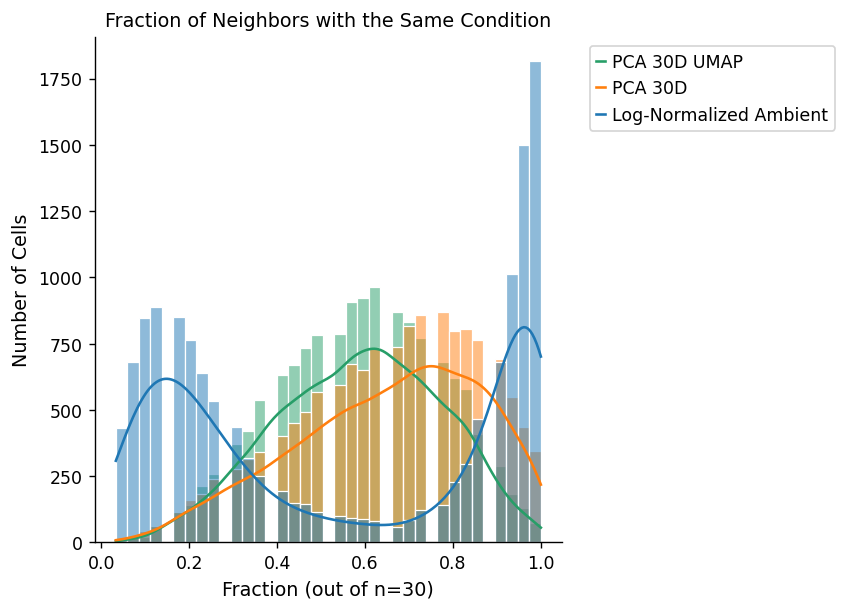

In [58]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 1250x625 with 0 Axes>

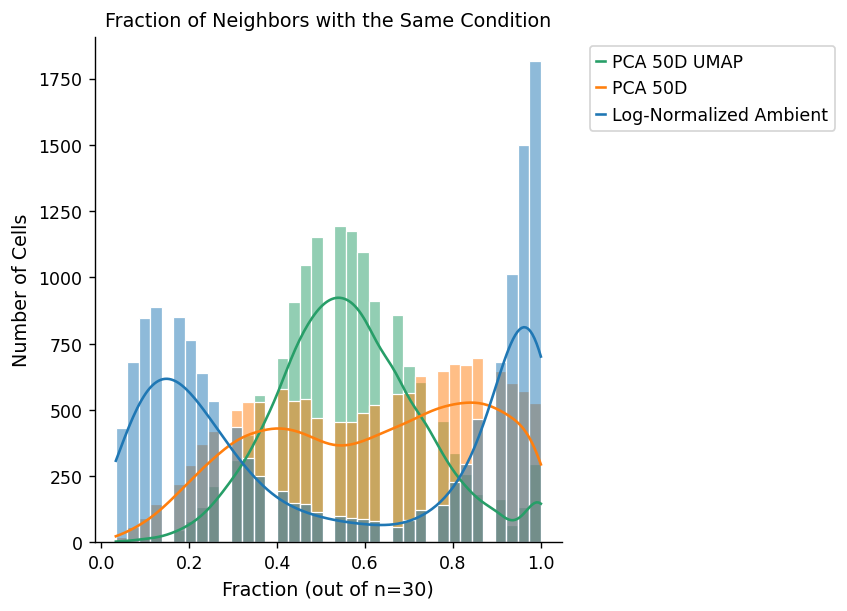

In [59]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 50D UMAP','PCA 50D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['PCA 50D UMAP','PCA 50D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 1250x625 with 0 Axes>

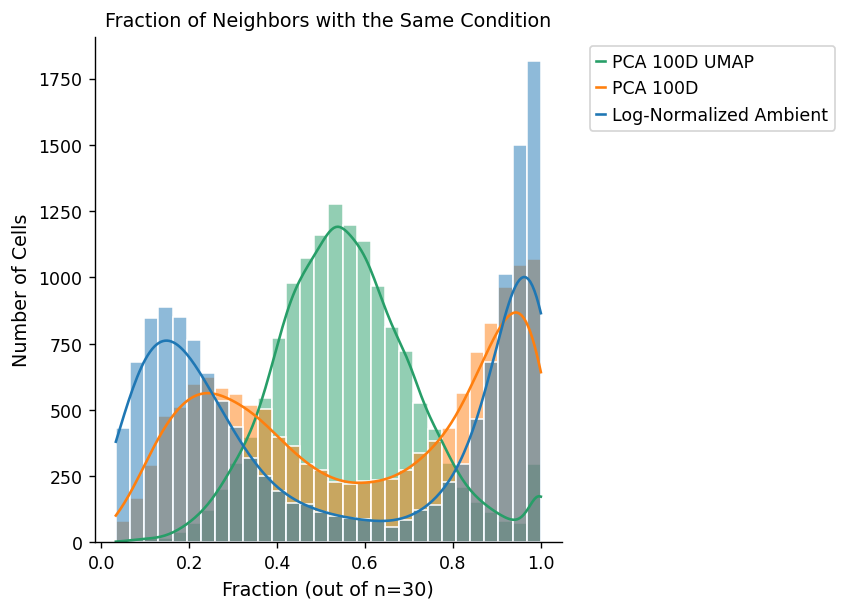

In [60]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 100D UMAP','PCA 100D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['PCA 100D UMAP','PCA 100D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 1250x625 with 0 Axes>

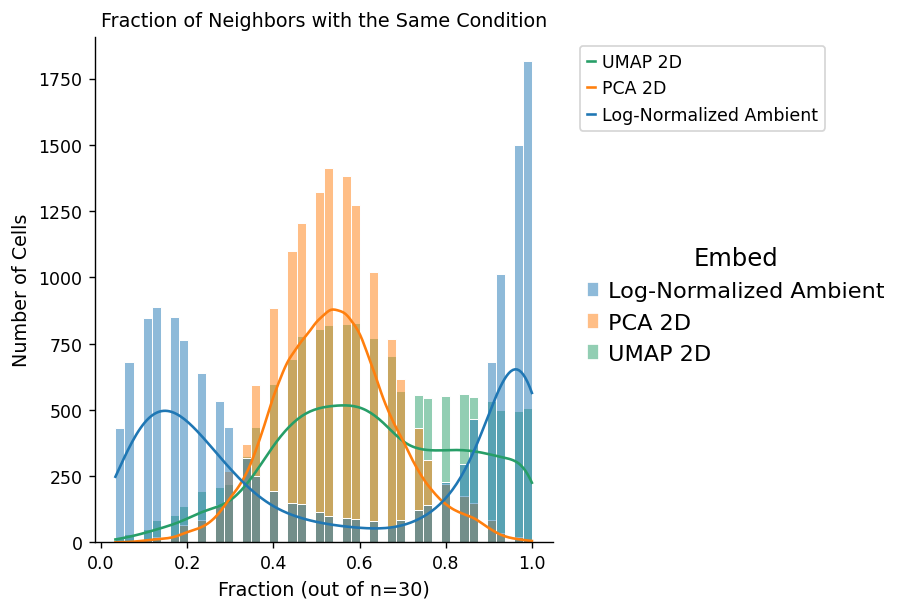

In [51]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 2D','UMAP 2D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',edgecolor="white") #legend=False

plt.legend(['UMAP 2D','PCA 2D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

Make plots for pre-integration matrix + embedding

**Plots for Pre-Integrated Data**

In [42]:
logNeigh, logClus = frac_unique_neighbors(np.asarray(logMatOrig), conds['x']) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(x_pca), conds['x']) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pcaUMAP), conds['x']) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latent = ['Log-Normalized Ambient (Pre-integration)','PCA 30D','30D PCA UMAP']

In [43]:
#Make dataframe

integDF = pd.DataFrame()
integDF['Fraction'] = latents[0] + latents[1] + latents[2]
integDF['Embed'] = ['Log-Normalized Ambient']*len(latents[0]) + ['PCA 30D']*len(latents[1]) + ['30D PCA UMAP']*len(latents[2])
integDF.head()

,Fraction,Embed
0,1.0,Log-Normalized Ambient
1,1.0,Log-Normalized Ambient
2,1.0,Log-Normalized Ambient
3,1.0,Log-Normalized Ambient
4,1.0,Log-Normalized Ambient


In [44]:
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['30D PCA UMAP'])]))

1.0
0.7
1.0


<Figure size 1250x625 with 0 Axes>

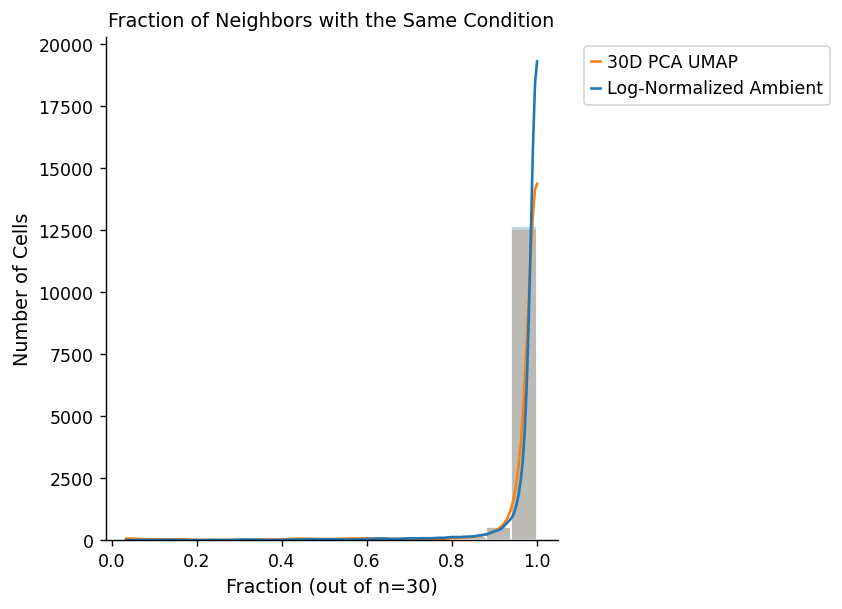

In [45]:
plt.figure(figsize=(10,5))

integDF = integDF[integDF['Embed'].isin(['30D PCA UMAP','Log-Normalized Ambient'])]

g=sns.displot(data=integDF, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white", alpha=0.3) 

plt.legend(['30D PCA UMAP','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

Plot for high d PCA embeddings and 2d PCA and UMAP

In [ ]:
logNeigh, logClus = frac_unique_neighbors(np.asarray(logMatOrig), conds['x']) #
pca50Neigh, pca50Clus = frac_unique_neighbors(np.asarray(x_pca_50), conds['x']) #pcaTSNE2
pca100Neigh, pca100Clus = frac_unique_neighbors(np.asarray(x_pca_100), conds['x']) #pcaTSNE2

pca50UMAPNeigh, pca50Clus = frac_unique_neighbors(np.asarray(pcaUMAP50), conds['x']) #pcaTSNE2
pca100UMAPNeigh, pca100Clus = frac_unique_neighbors(np.asarray(pcaUMAP100), conds['x']) #pcaTSNE2

pca2Neigh, pca2Clus = frac_unique_neighbors(np.asarray(x_pca_2), conds['x']) #pcaTSNE2
umap2Neigh, umap2Clus = frac_unique_neighbors(np.asarray(origUMAP2), conds['x']) #pcaTSNE2


#umapNeigh, umapClus = frac_unique_neighbors(np.asarray(umapMat), conds['x']) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pca50Neigh.values()),[]),sum(list(pca100Neigh.values()),[]),
           sum(list(pca50UMAPNeigh.values()),[]),sum(list(pca100UMAPNeigh.values()),[]),
           sum(list(pca2Neigh.values()),[]),sum(list(umap2Neigh.values()),[]) ]

latent = ['Log-Normalized Ambient','PCA 50D','PCA 100D','PCA 50D UMAP','PCA 100D UMAP','PCA 2D','UMAP 2D']

In [ ]:
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(x_pca), conds['x']) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pcaUMAP), conds['x']) #pcaUMAP2 


latents += [sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latent += ['PCA 30D','PCA 30D UMAP']

In [ ]:
#Make dataframe

integDF = pd.DataFrame()

all = []
names = []
for i in range(len(latents)):
  all += latents[i]
  names += [latent[i]]*len(latents[i])

integDF['Fraction'] = all
integDF['Embed'] = names
integDF.head()

,Fraction,Embed
0,1.0,Log-Normalized Ambient
1,1.0,Log-Normalized Ambient
2,1.0,Log-Normalized Ambient
3,1.0,Log-Normalized Ambient
4,1.0,Log-Normalized Ambient


In [ ]:
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D UMAP'])]))

print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 50D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 100D'])])) #'PCA 50D UMAP','PCA 100D UMAP','PCA 2D','UMAP 2D'

print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 2D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['UMAP 2D'])]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0


<Figure size 1250x625 with 0 Axes>

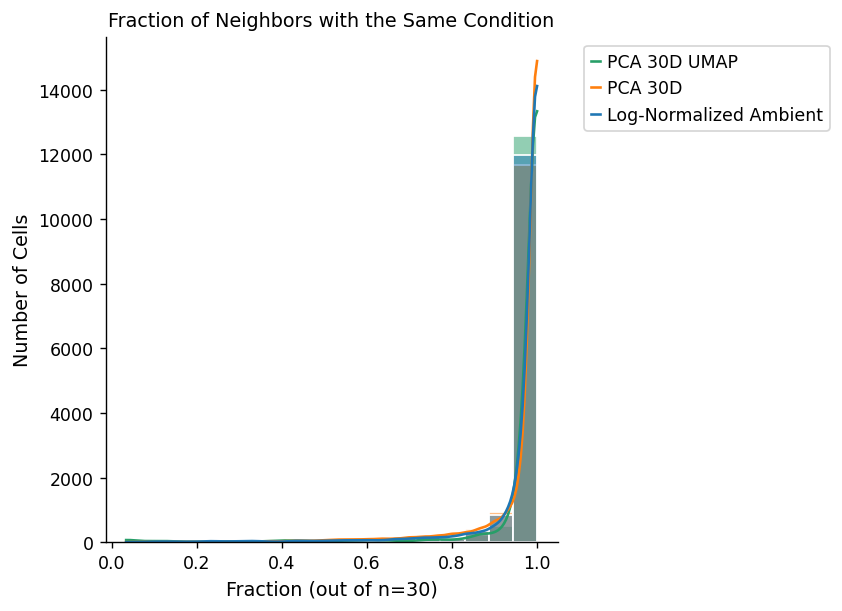

In [ ]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

#plt.yscale('log')

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 1250x625 with 0 Axes>

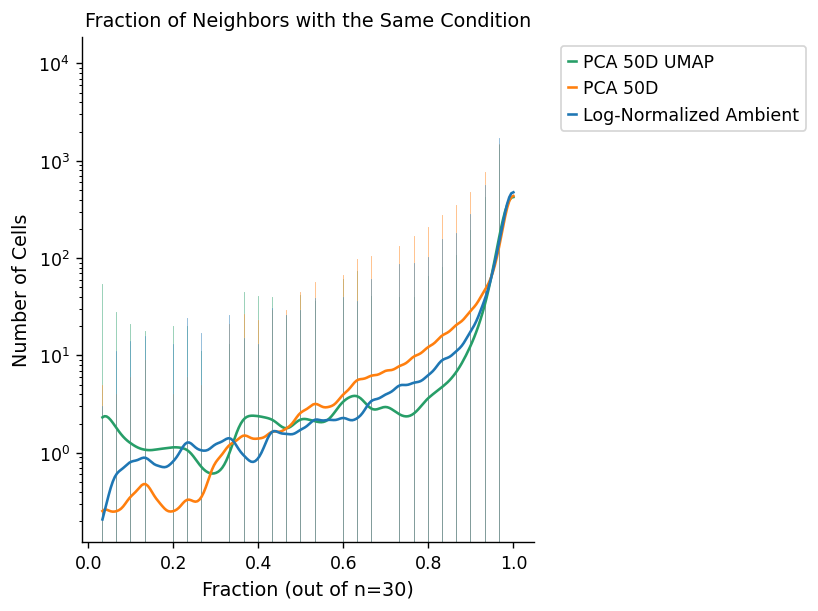

In [ ]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 50D UMAP','PCA 50D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['PCA 50D UMAP','PCA 50D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.yscale('log')

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 1250x625 with 0 Axes>

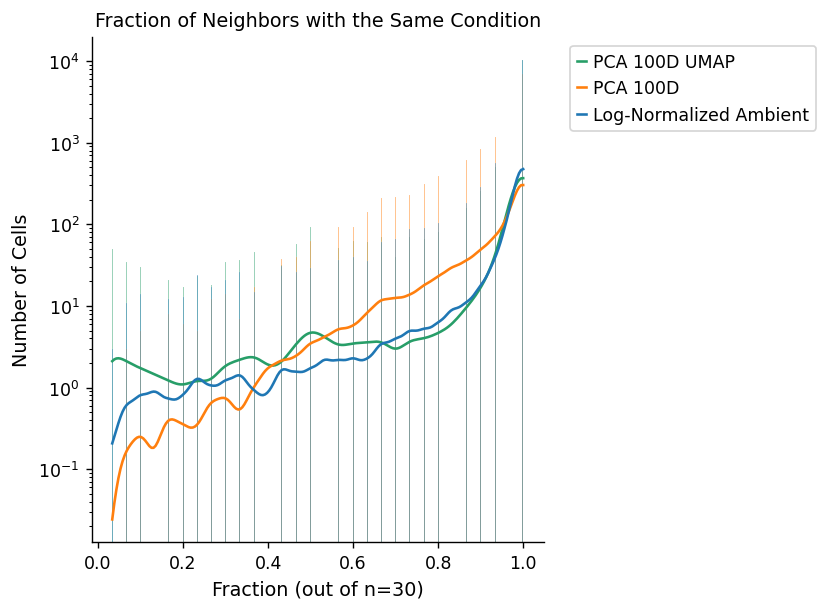

In [ ]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 100D UMAP','PCA 100D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['PCA 100D UMAP','PCA 100D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.yscale('log')

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 1250x625 with 0 Axes>

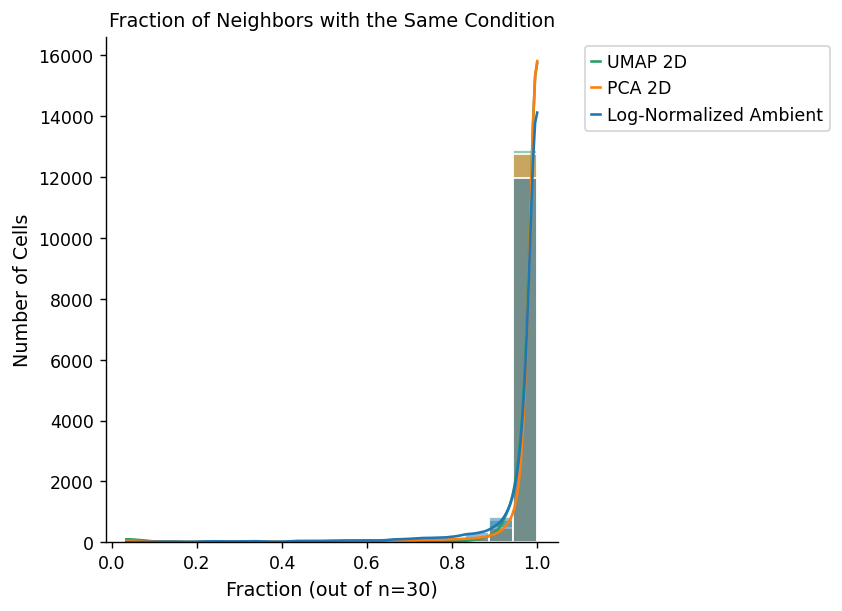

In [ ]:
plt.figure(figsize=(10,5))

integDF2 = integDF[integDF['Embed'].isin(['PCA 2D','UMAP 2D','Log-Normalized Ambient'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['UMAP 2D','PCA 2D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

#plt.yscale('log')
plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()